# WaveRNN - Fit a Sample

In [1]:
import os
os.chdir('/veu4/usuaris26/footanalytics/segmentation/asmr-is-all-you-need/notebooks/training')

print(os.getcwd())


import sys
sys.path.append('../../')
sys.path.append('../../network')

/veu4/usuaris26/footanalytics/segmentation/asmr-is-all-you-need/notebooks/training


In [2]:
import time, sys, math
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import wavfile
from librosa import resample
from src.display import *
from src.dsp import *
from models.wavernn import WaveRNN

In [3]:
import matplotlib.pyplot as plt
import time, sys, math
import numpy as np

def plot(array) : 
    fig = plt.figure(figsize=(30, 5))
    ax = fig.add_subplot(111)
    ax.xaxis.label.set_color('grey')
    ax.yaxis.label.set_color('grey')
    ax.xaxis.label.set_fontsize(23)
    ax.yaxis.label.set_fontsize(23)
    ax.tick_params(axis='x', colors='grey', labelsize=23)
    ax.tick_params(axis='y', colors='grey', labelsize=23)
    plt.plot(array)

In [4]:
notebook_name = 'glass_sample_PJ_v1'
sample_rate = 22050
epochs = 10000

In [5]:
sr, sample = wavfile.read('../../data/audio/prova_glass.wav')

In [6]:
#Stereo to mono
sample = sample.sum(axis=1) / 2

In [7]:
#downsample from original freq to sample_rate
sample = resample(sample, orig_sr = sr, target_sr = sample_rate)

In [8]:
sample = sample.astype(np.int16)

In [9]:
print(sample.max(), sample.min())

2171 -3199


### Split/Combine Functions

In [22]:
def split_signal(x) :
    unsigned = x + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

def split_signal_PJ(x) :
    minim = x.min()
    maxim = x.max()
    unsigned = ((x-minim) / (maxim-minim)) * 2**16
    unsigned = unsigned.astype(np.int16)
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [23]:
def combine_signal(coarse, fine) :
    return coarse * 256 + fine - 2**15

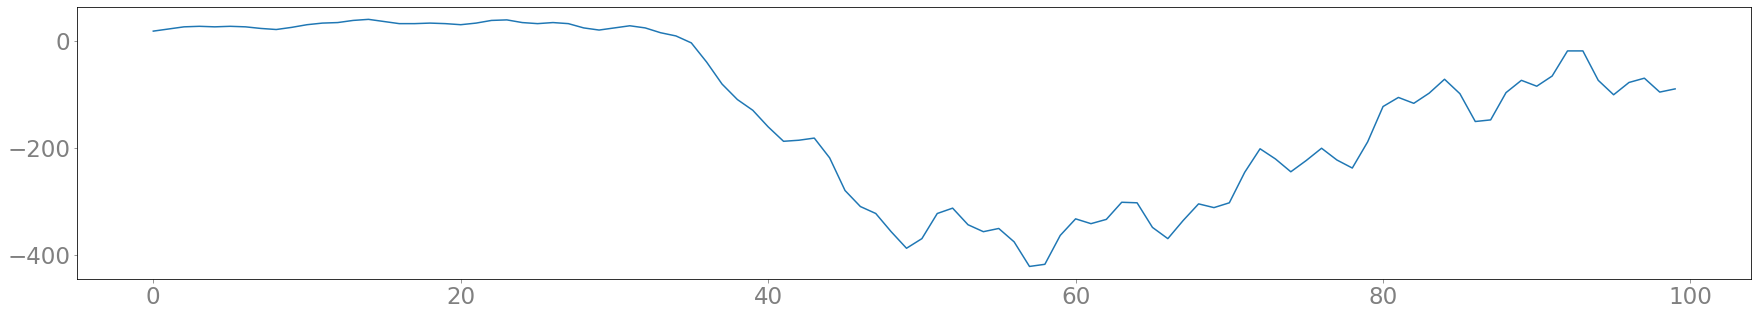

In [24]:
plot(sample[73000:73100])

In [25]:
coarse_classes, fine_classes = split_signal_PJ(sample)

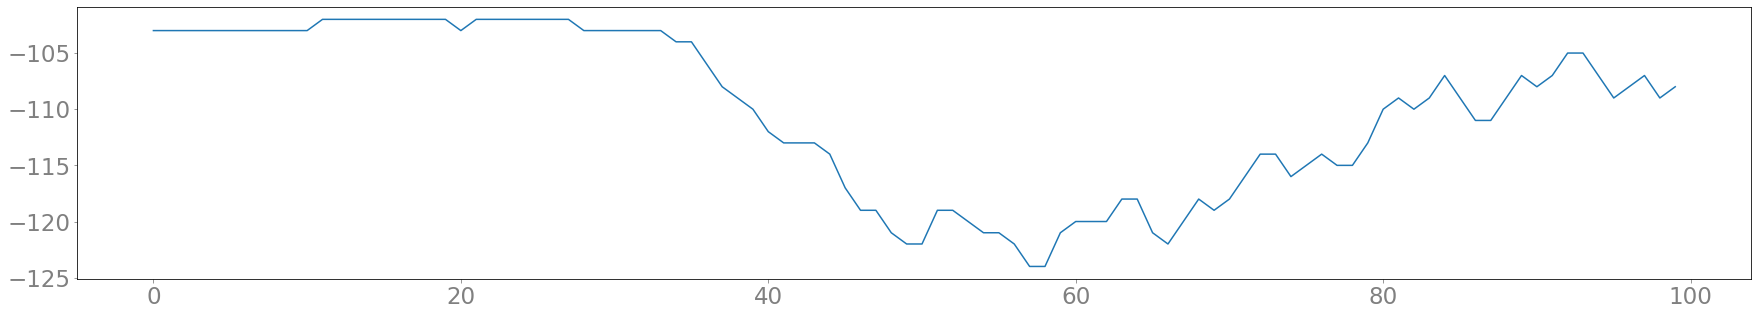

In [26]:
plot(coarse_classes[73000:73100])

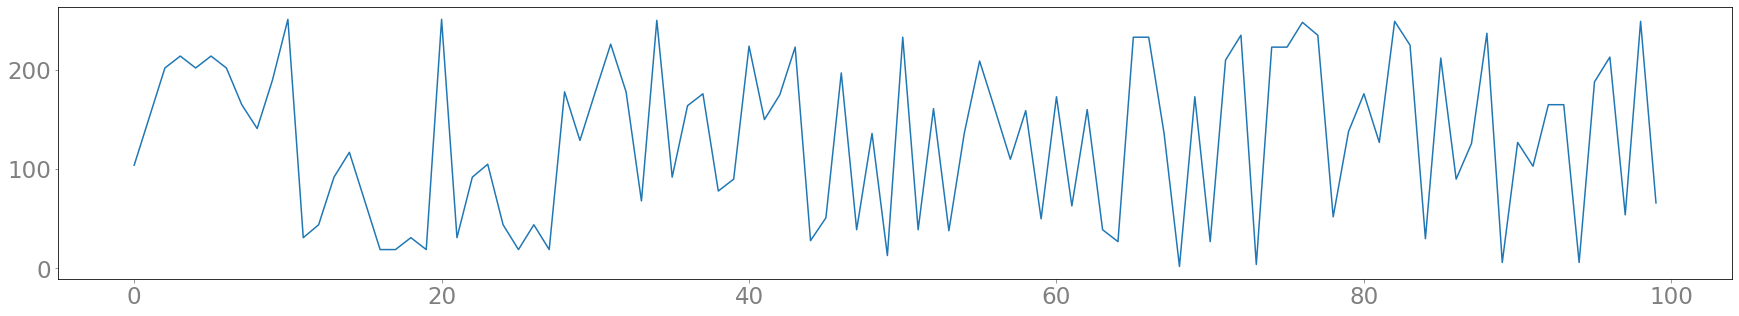

In [27]:
plot(fine_classes[73000:73100])

### Train Model

In [28]:
model = WaveRNN().cuda()

Trainable Parameters: 3.050 million


In [29]:
coarse_classes, fine_classes = split_signal(sample)

In [30]:
batch_size = 128 # 8gb gpu
coarse_classes = coarse_classes[:len(coarse_classes) // batch_size * batch_size]
fine_classes = fine_classes[:len(fine_classes) // batch_size * batch_size]
coarse_classes = np.reshape(coarse_classes, (batch_size, -1))
fine_classes = np.reshape(fine_classes, (batch_size, -1))

In [31]:
coarse_classes.shape

(128, 28096)

In [44]:
total_losses = []
coarse_losses = []
fine_losses = []

In [50]:
def train(model, optimizer, num_steps, batch_size, lr=1e-3, seq_len=960) :
    
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    
    running_loss = 0
    running_c_loss = 0
    running_f_loss = 0

    
    for step in range(num_steps) :
        
        loss = 0
        sum_loss_coarse = 0
        sum_loss_fine = 0
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        x_coarse = coarse_classes[:, rand_idx:rand_idx + seq_len]
        x_coarse = torch.FloatTensor(x_coarse)
        x_coarse = x_coarse / 127.5 - 1.
        x_fine = fine_classes[:, rand_idx:rand_idx + seq_len]
        x_fine = torch.FloatTensor(x_fine)
        x_fine = x_fine / 127.5 - 1.
        
        y_coarse = coarse_classes[:, rand_idx + 1:rand_idx + seq_len + 1]
        y_coarse = torch.LongTensor(y_coarse)
        y_fine = fine_classes[:, rand_idx + 1: rand_idx + seq_len + 1]
        y_fine = torch.LongTensor(y_fine)
        
        for i in range(seq_len) :
            
            x_c_in = x_coarse[:, i:i + 1]
            x_f_in = x_fine[:, i:i + 1]
            x_input = torch.cat([x_c_in, x_f_in], dim=1)
            x_input = x_input.cuda()
            
            c_target = y_coarse[:, i].cuda()
            f_target = y_fine[:, i].cuda()
            
            
            current_coarse = c_target.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, c_target)
            loss_fine = F.cross_entropy(out_fine, f_target)
            loss += (loss_coarse + loss_fine)
            sum_loss_coarse += loss_coarse
            sum_loss_fine += loss_fine
        
        running_loss += (loss.item() / seq_len)
        running_c_loss += (sum_loss_coarse.item() / seq_len)
        running_f_loss += (sum_loss_fine.item() / seq_len)
        loss.backward()
        optimizer.step()
        
        total_losses.append(running_loss / (step + 1))
        coarse_losses.append(running_c_loss / (step + 1))
        fine_losses.append(running_f_loss / (step + 1))
        
        elapsed = time_since(start)
        speed = (step + 1) / (time.time() - start)
        
        stream('Step: %i/%i --- Loss: %.3f --- %s --- @ %.2f batches/sec ',
              (step + 1, num_steps, running_loss / (step + 1), elapsed, speed))         

In [51]:
optimizer = optim.Adam(model.parameters())

In [52]:
train(model, optimizer, num_steps=epochs, batch_size=batch_size, lr=1e-3)

Step: 3/10000 --- Loss: 4.000 --- 0m 13s --- @ 0.22 batches/sec 

KeyboardInterrupt: 

In [53]:
torch.save(model.state_dict(), f'../../network/weights/wavernn/model_{notebook_name}.pt')

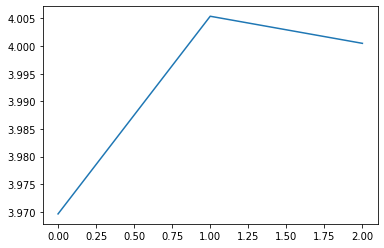

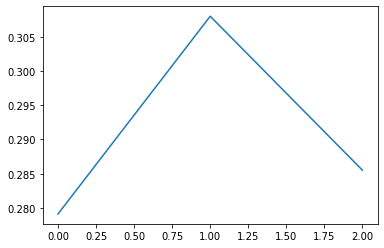

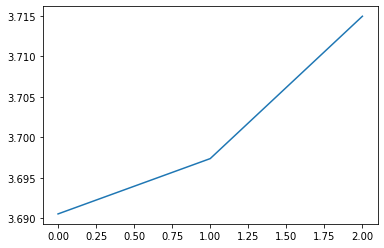

In [54]:
plt.plot(total_losses)
plt.show()
plt.plot(coarse_losses)
plt.show()
plt.plot(fine_losses)
plt.show()

In [55]:
def save_wav(y, filename, sample_rate) :
    y = np.clip(y, -2**15, 2**15 - 1)
    wavfile.write(filename, sample_rate, y.astype(np.int16))

In [56]:
num_samples = sample_rate * 15
output, c, f = model.generate(num_samples)
our_output = combine_signal(c, f)

Gen: 2226/330750 -- Speed: 362

KeyboardInterrupt: 

In [57]:
versio = 1
material = "glass"
output_path = f'gen_{notebook_name}_{material}_{versio}.wav'
save_wav(output, output_path, sample_rate)

NameError: name 'output' is not defined

In [ ]:
versio = 1
material = "our_glass"
output_path = f'../../network/outputs/gen_{notebook_name}_{material}_{versio}.wav'
save_wav(our_output, output_path, sample_rate)